In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image

***Note that the first few cells have processing of image required for the algorithm***
The algorithm is designed after referring to a few research papers and open source contributions

In [2]:
image = cv2.imread('images/90.JPEG')
image_copy = np.copy(image)
i=0

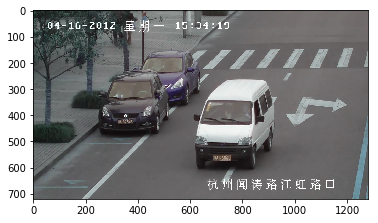

In [3]:
# Image
plt.imshow(image)

In [4]:
# Convert into grayscale
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
gray_copy = np.copy(gray)

In [5]:
# Processing of image
gray = cv2.GaussianBlur(gray, (3,3), 0)
edge_im = cv2.Sobel(gray, -1, 1, 0)
h,sobel = cv2.threshold(edge_im,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
se = cv2.getStructuringElement(cv2.MORPH_RECT, (11,3)) #Choice of rectangle size can affect the result
final_gray = cv2.morphologyEx(sobel, cv2.MORPH_CLOSE, se)

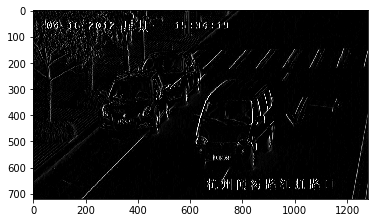

In [6]:
# Detecting vertical edges
plt.imshow(edge_im,cmap='gray')

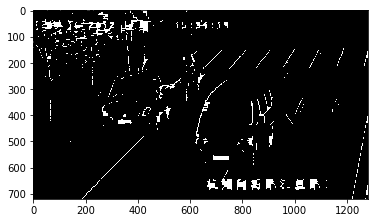

In [7]:
# After erosion and dilation (convolution algorithm) all the rectangles are isolated
plt.imshow(final_gray,cmap='gray')

In [8]:
# Contour selection
cnt_image,cnts,_=cv2.findContours(final_gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

Below is the implementation of the algorithm. The image after being processed as above is fed to the algorithm.

In [9]:
def radian_to_degree(angle):
    return angle*180/np.pi

In [10]:
def order_points(pts):
    ''' 
        The function returns the 4 corner points in a set of points and returns the rectangle formed by the four
        co-ordinates. 
        
        The input are a set of points (pts).
        
        'crop' is the amount of pixels that are subtracted from the points obtained which is kind of padding 
        so that we don't lose the data that run outside the area specified.
        
        'main' is the flag which exclusively runs when the ordering points are of the main form. If main is 1, then
        the cropping should be more (This is specific to the form that we have chosen)
    '''
    rect = np.zeros((4, 2), dtype = "float32")
 

    s = pts.sum(axis = 1)

    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
 

    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    # Cropping a little bit more towards right
    rect[1][0]+=10
    rect[2][0]+=10
 
    return rect

In [11]:
def four_point_warp(image, pts):
    ''' 
        The function finds the corner four points of the image and warps the image accordingly.
        
        image : The grayscale image of the scanned form.
        
        pts   : The set of points from which corner points are to be selected to warp.
        
    '''

    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    # Finding width and height of the image based on corner points
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    # The destination where the image needs to be pasted. 
    # This is the size of the image where the warped image will be put.
    dst = np.array([
              [0, 0],
              [maxWidth - 1, 0],
              [maxWidth - 1, maxHeight - 1],
              [0, maxHeight - 1]], dtype = "float32")
    
    # Warping the image
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
 
    return np.array(rect),warped

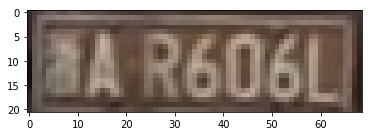

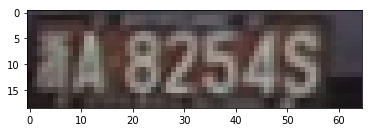

In [12]:
# The below four variables affect the rectangles that are chosen. Choosing the right values of these variables determine
# the result of the algorithm

area_range = [200,5000] 
aspect_ratio_range = [2.4,9]
angle_thresh = 5
edge_density_threshold = 0.5
for contour in cnts:
    rect = cv2.minAreaRect(contour)
    img_width = gray.shape[1]
    img_height = gray.shape[0]
    area = img_width*img_height

    box = cv2.boxPoints(rect) 
    box = np.int0(box)

    X = rect[0][0]
    Y = rect[0][1]
    angle = rect[2] 
    width = rect[1][0]
    height = rect[1][1]

    angle = (angle + 180) if width < height else (angle + 90)

    
    if (width > 0 and height > 0) and ((width < img_width/2.0) 
             and (height < img_width/2.0)):
        aspect_ratio = float(width)/height if width > height else float(height)/width
        
        if (aspect_ratio >= aspect_ratio_range[0] and aspect_ratio <= aspect_ratio_range[1]):
            if((height*width > area_range[0]) and (height*width < area_range[1])):
                box_list = list(box)
                random_point = box_list[0]
                del(box_list[0])
                distances = [((point[0]-random_point[0])**2 + (point[1]-random_point[1])**2) for point in box_list]
                sorted_distances = sorted(distances)
                adjacent_far_point = box_list[distances.index(sorted_distances[1])]
                tmp_angle = 90

                if abs(random_point[0]-adjacent_far_point[0]) > 0:
                    tmp_angle = abs(float(random_point[1]-adjacent_far_point[1]))/ \
                                abs(random_point[0]-adjacent_far_point[0])
                    tmp_angle = radian_to_degree(math.atan(tmp_angle))
                                    
                if tmp_angle <= angle_thresh:
                    rect,warped = four_point_warp(image, box)
                    warped_gray = cv2.cvtColor(warped,cv2.COLOR_BGR2GRAY)
                    h,thresh = cv2.threshold(warped_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
                    #thresh = cv2.bitwise_not(thresh)
                    
                    white_pixels=0
                    for i in range(thresh.shape[0]):
                            for j in range(thresh.shape[1]):
                                if thresh[i][j] == 255:
                                    white_pixels += 1
                                    
                    """ Edge density approach can also be used. Below code represents the algorithm"""
#                     edge_density = float(white_pixels)/(thresh.shape[0]*thresh.shape[1])
#                     print(edge_density)
#                     if edge_density > edge_density_threshold :
#                         cv2.drawContours(image, [box], 0, (255,0,0),2)
#                         #cv2.imwrite('plate'+str(i)+'.jpg',warped)
#                         i=i+1
#                         plt.imshow(warped,cmap='gray')
#                         plt.show()
                        
                    """Below algorithm was tried to consider the factor that license plate has characters"""

                    need,contrs,hier=cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

                    count = 0
                    for contour in contrs:
                        a = cv2.contourArea(contour)
                        t = warped.shape[0]*warped.shape[1]
                        if a > t/30 and a<t/5: # Choosing the contours with right area here is the vital and changing
                                               # the values gives different results
                            count= count+1
                    if count > 0: 
                        cv2.drawContours(image, [box], 0, (255,0,0),2)
                        plt.imshow(warped,cmap='gray')
                        plt.show()

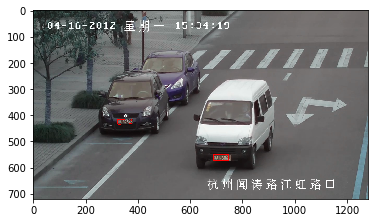

In [13]:
plt.imshow(image,cmap='gray')